In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

In [2]:
TW = yf.download('^TWII')

[*********************100%%**********************]  1 of 1 completed


In [3]:
prices = TW['Adj Close']

lambda1 = 0.20  # 牛市狀態的價格上漲閾值
lambda2 = 0.10  # 熊市狀態的價格下跌閾值

# 建立狀態記錄的 DataFrame，包含 'bull'（牛市）和 'bear'（熊市）兩列
states = pd.DataFrame(index=prices.index, columns=['bull', 'bear'])
states[:] = 0  # 初始化所有狀態為 0
current_state = 'bull'  # 初始狀態設定為牛市
P_max = prices.iloc[0]  # 初始化最大價格
P_min = prices.iloc[0]  # 初始化最小價格
t0 = prices.index[0]  # 初始化開始時間

# 定義函數以找到第一次通過指定閾值的時間
def first_passage_time(prices, start, threshold, direction='up'):
    for i in prices.loc[start:].index:
        if (direction == 'up' and prices.loc[i] >= threshold) or (direction == 'down' and prices.loc[i] <= threshold):
            return i  # 返回第一次通過閾值的時間
    return prices.index[-1]  # 如果未找到通過點，返回序列的最後時間

# 遍歷價格數據以更新市場狀態
for t in prices.index:
    print(t)
    if current_state == 'bull':  # 當前狀態為牛市
        tau_max = first_passage_time(prices, t, P_max, 'up')  # 找到價格上升超過 P_max 的時間
        tau_min = first_passage_time(prices, t, (1 - lambda2) * P_max, 'down')  # 找到價格下跌超過閾值的時間
        if tau_max < tau_min:  # 如果價格上升的時間早於下跌的時間
            P_max = prices.loc[tau_max]  # 更新最大價格
            states.loc[t:tau_max, 'bull'] = 1  # 標記牛市狀態
            t = tau_max
        else:  # 如果價格下跌的時間早於上升的時間
            states.loc[t:t, 'bull'] = 1  # 確保當前時間點記錄為牛市
            states.loc[t0:tau_min, 'bear'] = 1  # 標記熊市狀態
            current_state = 'bear'  # 切換到熊市狀態
            P_min = prices.loc[tau_min]  # 更新最小價格
            t0 = tau_min
    elif current_state == 'bear':  # 當前狀態為熊市
        tau_min = first_passage_time(prices, t, P_min, 'down')  # 找到價格下跌超過 P_min 的時間
        tau_max = first_passage_time(prices, t, (1 + lambda1) * P_min, 'up')  # 找到價格上升超過閾值的時間
        if tau_min < tau_max:  # 如果價格下跌的時間早於上升的時間
            P_min = prices.loc[tau_min]  # 更新最小價格
            states.loc[t:tau_min, 'bear'] = 1  # 標記熊市狀態
            t = tau_min
        else:  # 如果價格上升的時間早於下跌的時間
            states.loc[t:t, 'bear'] = 1  # 確保當前時間點記錄為熊市
            states.loc[t0:tau_max, 'bull'] = 1  # 標記牛市狀態
            current_state = 'bull'  # 切換到牛市狀態
            P_max = prices.loc[tau_max]  # 更新最大價格
            t0 = tau_max

# 確保牛市和熊市狀態互斥
states['bull'] = states['bull'].fillna(0)  # 填補牛市狀態的空值
states['bear'] = states['bear'].fillna(0)  # 填補熊市狀態的空值
states['bull'] = states['bull'] * (1 - states['bear'])  # 確保牛市和熊市狀態不重疊

# 檢查牛市和熊市狀態之間的衝突
conflict = (states['bull'] & states['bear']).sum()  # 計算牛市和熊市同時出現的次數
print(f'牛市和熊市狀態之間的衝突: {conflict}')


1997-07-02 00:00:00
1997-07-03 00:00:00
1997-07-04 00:00:00
1997-07-07 00:00:00
1997-07-08 00:00:00
1997-07-09 00:00:00
1997-07-10 00:00:00
1997-07-11 00:00:00
1997-07-14 00:00:00
1997-07-15 00:00:00
1997-07-16 00:00:00
1997-07-17 00:00:00
1997-07-18 00:00:00
1997-07-21 00:00:00
1997-07-22 00:00:00
1997-07-23 00:00:00
1997-07-24 00:00:00
1997-07-25 00:00:00
1997-07-28 00:00:00
1997-07-29 00:00:00
1997-07-30 00:00:00
1997-07-31 00:00:00
1997-08-01 00:00:00
1997-08-04 00:00:00
1997-08-05 00:00:00
1997-08-06 00:00:00
1997-08-07 00:00:00
1997-08-08 00:00:00
1997-08-11 00:00:00
1997-08-12 00:00:00
1997-08-13 00:00:00
1997-08-14 00:00:00
1997-08-15 00:00:00
1997-08-19 00:00:00
1997-08-20 00:00:00
1997-08-21 00:00:00
1997-08-22 00:00:00
1997-08-25 00:00:00
1997-08-26 00:00:00
1997-08-27 00:00:00
1997-08-28 00:00:00
1997-09-01 00:00:00
1997-09-02 00:00:00
1997-09-03 00:00:00
1997-09-04 00:00:00
1997-09-05 00:00:00
1997-09-08 00:00:00
1997-09-09 00:00:00
1997-09-10 00:00:00
1997-09-11 00:00:00


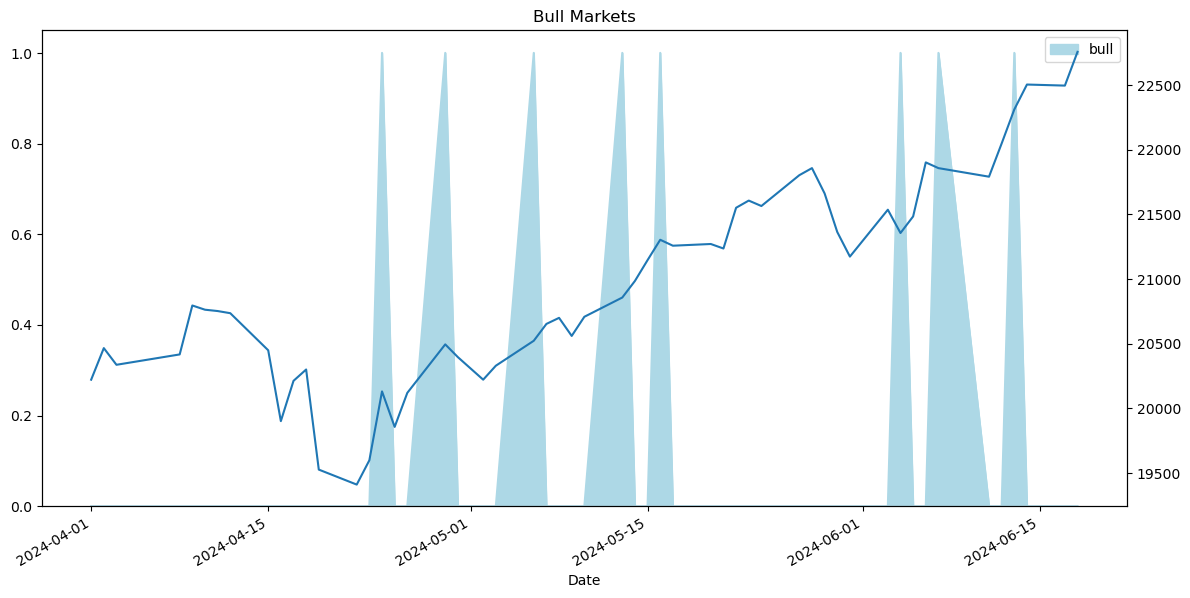

In [4]:
states[['bull']].loc['2024-4':].plot.area(figsize=(14, 7), color = 'lightblue')
prices.loc['2024-4':].plot(secondary_y = True)
plt.title('Bull Markets')
plt.savefig('Downloads/bull_duration.png')

## GARCH, RANDOM WALK

In [4]:
from arch import arch_model

In [5]:
prices = prices = TW['Adj Close']
returns = np.log(prices / prices.shift(1)).dropna()

### 隨機漫步模型
np.random.seed(42)
rw_prices = prices.iloc[0] * np.exp(np.cumsum(np.random.normal(returns.mean(), returns.std(), len(prices))))

### GARCH模型
# 定義GARCH(1,1)模型
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# 生成模擬收益
simulated_garch = garch_model.simulate(params=garch_fit.params, nobs=len(prices))
garch_prices = prices.iloc[0] * np.exp(np.cumsum(simulated_garch['data']))

In [6]:
from arch import arch_model

### GARCH模型
# 定義GARCH(1,1)模型
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# 生成模擬收益
simulated_garch = garch_model.simulate(params=garch_fit.params, nobs=len(prices))
garch_prices = prices.iloc[0] * np.exp(np.cumsum(simulated_garch['data']))

C:\Users\Public\AnacondaNew\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001798. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [7]:
prices = pd.DataFrame(TW['Adj Close'])
prices.columns = ['Actual data']
prices['Random Walk'] = list(rw_prices)
prices['GARCH'] = list(garch_prices.values)

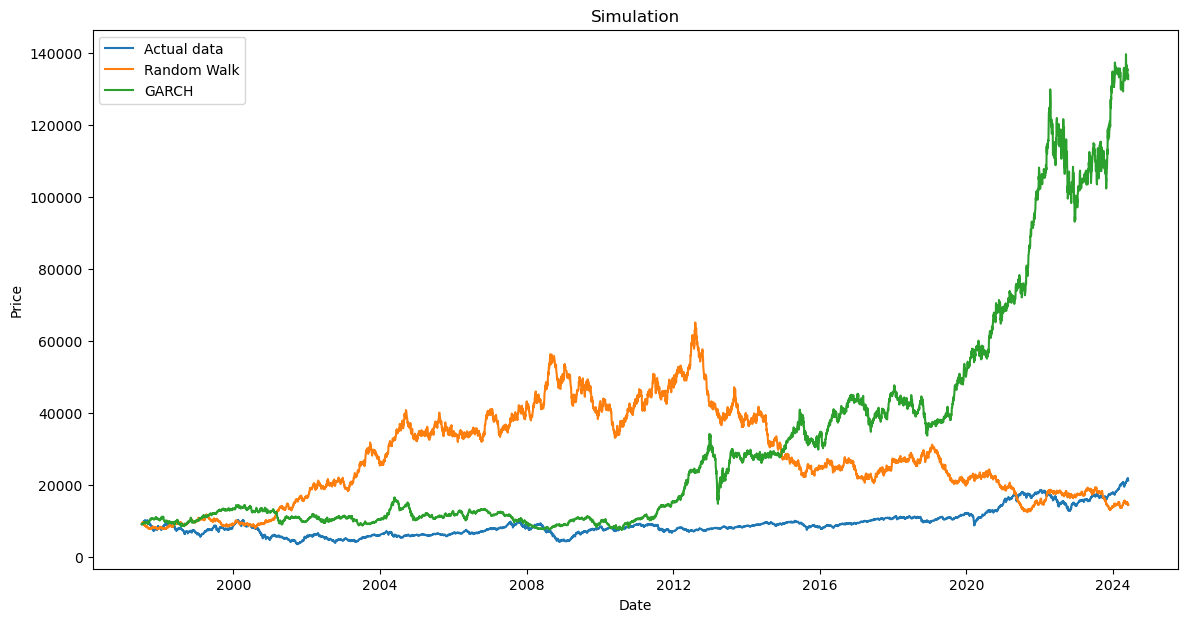

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(prices['Actual data'], label='Actual data')
plt.plot(prices['Random Walk'], label='Random Walk')
plt.plot(prices['GARCH'], label='GARCH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Simulation')
plt.legend()
plt.savefig('Downloads/Simulation.png')

In [117]:
# random_walk = prices['Random Walk']
#garch = prices['GARCH']
PRICE = prices['GARCH']


# 找到第一次通過時間的函數
def first_passage_time(PRICE, start, threshold, direction='up'):
    for i in PRICE.loc[start:].index:
        if (direction == 'up' and PRICE.loc[i] >= threshold) or (direction == 'down' and PRICE.loc[i] <= threshold):
            return i
    return PRICE.index[-1]  # 如果沒有找到通過點，返回序列的末尾
def STATE(PRICE):
    PRICE = PRICE
    lambda1 = 0.20
    lambda2 = 0.10
    states = pd.DataFrame(index=PRICE.index, columns=['bull', 'bear'])
    states[:] = 0  # 初始化為0
    current_state = 'bull'  # 初始狀態為牛市
    P_max = PRICE.iloc[0]
    P_min = PRICE.iloc[0]
    for t in PRICE.index:
        print(t)
        if current_state == 'bull':
            tau_max = first_passage_time(PRICE, t, P_max, 'up')
            tau_min = first_passage_time(PRICE, t, (1 - lambda2) * P_max, 'down')
            if tau_max < tau_min:
                P_max = PRICE.loc[tau_max]
                states.loc[t:tau_max, 'bull'] = 1
            else:
                states.loc[t:tau_min, 'bear'] = 1
                current_state = 'bear'
                P_min = PRICE.loc[tau_min]
        elif current_state == 'bear':
            tau_min = first_passage_time(PRICE, t, P_min, 'down')
            tau_max = first_passage_time(PRICE, t, (1 + lambda1) * P_min, 'up')
            if tau_min < tau_max:
                P_min = PRICE.loc[tau_min]
                states.loc[t:tau_min, 'bear'] = 1
            else:
                states.loc[t:tau_max, 'bull'] = 1
                current_state = 'bull'
                P_max = PRICE.loc[tau_max]
    
    # 確保 bull 和 bear 狀態互斥
    states['bull'] = states['bull'].fillna(0)
    states['bear'] = states['bear'].fillna(0)
    states['bear'] = states['bear'] * (1 - states['bull'])
    
    # 檢查 bull 和 bear 狀態是否互斥
    conflict = (states['bull'] & states['bear']).sum()
    print(f'牛市和熊市狀態之間的衝突: {conflict}')
    return states
ACTUAL_STATE = STATE(prices['Actual data'])
GARCH_STATE = STATE(prices['GARCH'])
RW_STATE = STATE(prices['Random Walk'])

1997-07-02 00:00:00
1997-07-03 00:00:00
1997-07-04 00:00:00
1997-07-07 00:00:00
1997-07-08 00:00:00
1997-07-09 00:00:00
1997-07-10 00:00:00
1997-07-11 00:00:00
1997-07-14 00:00:00
1997-07-15 00:00:00
1997-07-16 00:00:00
1997-07-17 00:00:00
1997-07-18 00:00:00
1997-07-21 00:00:00
1997-07-22 00:00:00
1997-07-23 00:00:00
1997-07-24 00:00:00
1997-07-25 00:00:00
1997-07-28 00:00:00
1997-07-29 00:00:00
1997-07-30 00:00:00
1997-07-31 00:00:00
1997-08-01 00:00:00
1997-08-04 00:00:00
1997-08-05 00:00:00
1997-08-06 00:00:00
1997-08-07 00:00:00
1997-08-08 00:00:00
1997-08-11 00:00:00
1997-08-12 00:00:00
1997-08-13 00:00:00
1997-08-14 00:00:00
1997-08-15 00:00:00
1997-08-19 00:00:00
1997-08-20 00:00:00
1997-08-21 00:00:00
1997-08-22 00:00:00
1997-08-25 00:00:00
1997-08-26 00:00:00
1997-08-27 00:00:00
1997-08-28 00:00:00
1997-09-01 00:00:00
1997-09-02 00:00:00
1997-09-03 00:00:00
1997-09-04 00:00:00
1997-09-05 00:00:00
1997-09-08 00:00:00
1997-09-09 00:00:00
1997-09-10 00:00:00
1997-09-11 00:00:00


In [143]:
#RW_STAT = pd.DataFrame()
#Actaul_STAT = pd.DataFrame()
#GARCH_STAT = pd.DataFrame()

states = GARCH_STATE
# 計算牛市的分組編號，當狀態從 0 變為 1 時，累加一個組編號
states['bull_group'] = ((states['bull'] - states['bull'].shift()) == 1).cumsum()
# 計算熊市的分組編號，當狀態從 0 變為 1 時，累加一個組編號
states['bear_group'] = ((states['bear'] - states['bear'].shift()) == 1).cumsum()

# 計算每個牛市和熊市的持續時間（天數）
bull_durations = states[states['bull'] == 1].groupby('bull_group').size()  # 分組統計每個牛市的天數
bear_durations = states[states['bear'] == 1].groupby('bear_group').size()  # 分組統計每個熊市的天數

# 統計牛市和熊市的數量
num_bull_markets = bull_durations.size  # 計算牛市的數量
num_bear_markets = bear_durations.size  # 計算熊市的數量

# 輸出牛市和熊市的數量
print(f"Number of Bull Markets: {num_bull_markets}")  # 顯示牛市的數量
print(f"Number of Bear Markets: {num_bear_markets}")  # 顯示熊市的數量

# 輸出前幾個牛市的持續時間
print("\nBull Market Durations:")  # 顯示牛市持續時間
print(bull_durations.head())

# 輸出前幾個熊市的持續時間
print("\nBear Market Durations:")  # 顯示熊市持續時間
print(bear_durations.head())



Number of Bull Markets: 16
Number of Bear Markets: 15

Bull Market Durations:
bull_group
0    136
1    366
2    200
3    101
4    246
dtype: int64

Bear Market Durations:
bear_group
1    126
2    303
3     84
4    133
5     35
dtype: int64


In [102]:
GARCH_STAT['Bear'] = bear_durations.describe()

In [103]:
GARCH_STAT['Bull'] = bull_durations.describe()

In [114]:
GARCH_STAT.to_pickle('GARCH_STAT')
RW_STAT.to_pickle('RW_STAT')
Actaul_STAT.to_pickle('Actaul_STAT')

In [109]:
BEAR_STAT = pd.DataFrame(Actaul_STAT['Bear'])
BEAR_STAT.columns = ['Actual']
BEAR_STAT['GARCH'] = GARCH_STAT['Bear']
BEAR_STAT['RW'] = RW_STAT['Bear']

In [111]:
BULL_STAT = pd.DataFrame(Actaul_STAT['Bull'])
BULL_STAT.columns = ['Actual']
BULL_STAT['GARCH'] = GARCH_STAT['Bull']
BULL_STAT['RW'] = RW_STAT['Bull']

In [113]:
BEAR_STAT

,Actual,GARCH,RW
count,19.000000,15.000000,16.000000
mean,105.052632,143.466667,167.937500
std,66.957261,131.394644,124.225853
min,18.000000,35.000000,60.000000
25%,46.000000,60.500000,88.250000
50%,82.000000,115.000000,126.000000
75%,151.500000,151.500000,196.750000
max,233.000000,539.000000,464.000000


In [112]:
BULL_STAT

,Actual,GARCH,RW
count,20.000000,16.000000,17.000000
mean,230.250000,278.062500,230.235294
std,244.463295,217.234886,146.251722
min,13.000000,26.000000,10.000000
25%,50.250000,127.250000,150.000000
50%,104.500000,248.500000,192.000000
75%,399.250000,352.500000,324.000000
max,730.000000,810.000000,561.000000


In [155]:
# 計算每個牛市和熊市的持續時間和回報率
def DURATION(PRICE, states):
    bull_durations = []
    bear_durations = []
    bull_returns = []
    bear_returns = []
    
    for state, group in states.groupby((states['bull'] != states['bull'].shift()).cumsum()):
        if group['bull'].iloc[0] == 1:
            start_price = PRICE[group.index[0]]
            end_price = PRICE[group.index[-1]]
            duration = len(group)
            return_rate = (end_price - start_price) / start_price
            bull_durations.append(duration)
            bull_returns.append(return_rate)
        elif group['bear'].iloc[0] == 1:
            start_price = PRICE[group.index[0]]
            end_price = PRICE[group.index[-1]]
            duration = len(group)
            return_rate = (end_price - start_price) / start_price
            bear_durations.append(duration)
            bear_returns.append(return_rate)
    

    bull_df = pd.DataFrame({'Duration': bull_durations, 'Return': bull_returns})
    bear_df = pd.DataFrame({'Duration': bear_durations, 'Return': bear_returns})
    return bull_df, bear_df
ACTUAL_BULL_DURATION, ACTUAL_BEAR_DURATION = DURATION(prices['Actual data'], ACTUAL_STATE)[0], DURATION(prices['Actual data'], ACTUAL_STATE)[1]
GARCH_BULL_DURATION, GARCH_BEAR_DURATION = DURATION(prices['GARCH'], GARCH_STATE)[0], DURATION(prices['GARCH'], GARCH_STATE)[1]
RW_BULL_DURATION,  RW_BEAR_DURATION = DURATION(prices['Random Walk'], RW_STATE)[0], DURATION(prices['Random Walk'], RW_STATE)[1]

In [156]:
BULL_RET_STAT = pd.DataFrame(ACTUAL_BULL_DURATION['Return'].describe())
BULL_RET_STAT.columns = ['Actual']
BULL_RET_STAT['GARCH'] = GARCH_BULL_DURATION['Return'].describe()
BULL_RET_STAT['RW'] = RW_BULL_DURATION['Return'].describe()

In [157]:
BEAR_RET_STAT = pd.DataFrame(ACTUAL_BEAR_DURATION['Return'].describe())
BEAR_RET_STAT.columns = ['Actual']
BEAR_RET_STAT['GARCH'] = GARCH_BEAR_DURATION['Return'].describe()
BEAR_RET_STAT['RW'] = RW_BEAR_DURATION['Return'].describe()

In [162]:
from scipy.stats import kstest, mannwhitneyu

In [175]:
ACTUAL_STATE.columns

Index(['bull', 'bear', 'bull_group', 'bear_group'], dtype='object')

In [176]:
# 統計測試：Kolmogorov-Smirnov檢定和Mann-Whitney U檢定
ks_stat, ks_p_value = kstest(ACTUAL_STATE['bull'], GARCH_STATE['bull'])
mw_stat, mw_p_value = mannwhitneyu(ACTUAL_STATE['bull'], GARCH_STATE['bull'])

print("\nActual-GARCH-BULL")
print("\nKolmogorov-Smirnov Test:")
print(f"p-value: {ks_p_value}")

print("\nMann-Whitney U Test:")
print(f"p-value: {mw_p_value}")

print("\n-------------------")
ks_stat, ks_p_value = kstest(ACTUAL_STATE['bear'], GARCH_STATE['bear'])
mw_stat, mw_p_value = mannwhitneyu(ACTUAL_STATE['bear'], GARCH_STATE['bear'])

print("\nActual-Gov-Smirnov Test:")
print(f"p-value:ARCH-BEAR")
print("\nKolmogor {ks_p_value}")

print("\nMann-Whitney U Test:")
print(f"p-value: {mw_p_value}")

print("\n-------------------")
ks_stat, ks_p_value = kstest(ACTUAL_STATE['bull'], RW_STATE['bull'])
mw_stat, mw_p_value = mannwhitneyu(ACTUAL_STATE['bull'], RW_STATE['bull'])

print("\nActual-RW-BULL")
print("\nKolmogorov-Smirnov Test:")
print(f"p-value: {ks_p_value}")

print("\nMann-Whitney U Test:")
print(f"Statistic: {mw_stat}, p-value: {mw_p_value}")

print("\n-------------------")
ks_stat, ks_p_value = kstest(ACTUAL_STATE['bear'], RW_STATE['bear'])
mw_stat, mw_p_value = mannwhitneyu(ACTUAL_STATE['bear'], RW_STATE['bear'])

print("\nActual-RW-BEAR")
print("\nKolmogorov-Smirnov Test:")
print(f"p-value: {ks_p_value}")

print("\nMann-Whitney U Test:")
print(f"Statistic: {mw_stat}, p-value: {mw_p_value}")


Actual-GARCH-BULL

Kolmogorov-Smirnov Test:
p-value: 0.050104395093901716

Mann-Whitney U Test:
p-value: 0.003447388424383828

-------------------

Actual-Gov-Smirnov Test:
p-value:ARCH-BEAR

Kolmogor {ks_p_value}

Mann-Whitney U Test:
p-value: 0.003447388424383828

-------------------

Actual-RW-BULL

Kolmogorov-Smirnov Test:
p-value: 6.780437530980786e-32

Mann-Whitney U Test:
Statistic: 24067246.0, p-value: 3.098899818853276e-36

-------------------

Actual-RW-BEAR

Kolmogorov-Smirnov Test:
p-value: 6.780437530980786e-32

Mann-Whitney U Test:
Statistic: 19505955.0, p-value: 3.098899818853276e-36


In [190]:
ACTUAL_BULL_DURATION['Duration'].values

array([ 39,  72,  54,  88, 121,  13,  18, 131,  65, 212, 730,  33,  74,
       546,  34, 711, 590, 247, 442, 385], dtype=int64)

In [188]:
bull_durations

array([3, 3, 4])

In [195]:
 hazard_rates_bull_static.cumsum()

array([0.04973651, 0.09947302, 0.14920953, 0.19894605, 0.24868256,
       0.29841907, 0.34815558, 0.39789209, 0.4476286 , 0.49736512,
       0.54710163, 0.59683814, 0.64657465, 0.69631116, 0.74604767,
       0.79578418, 0.8455207 , 0.89525721, 0.94499372, 0.99473023])

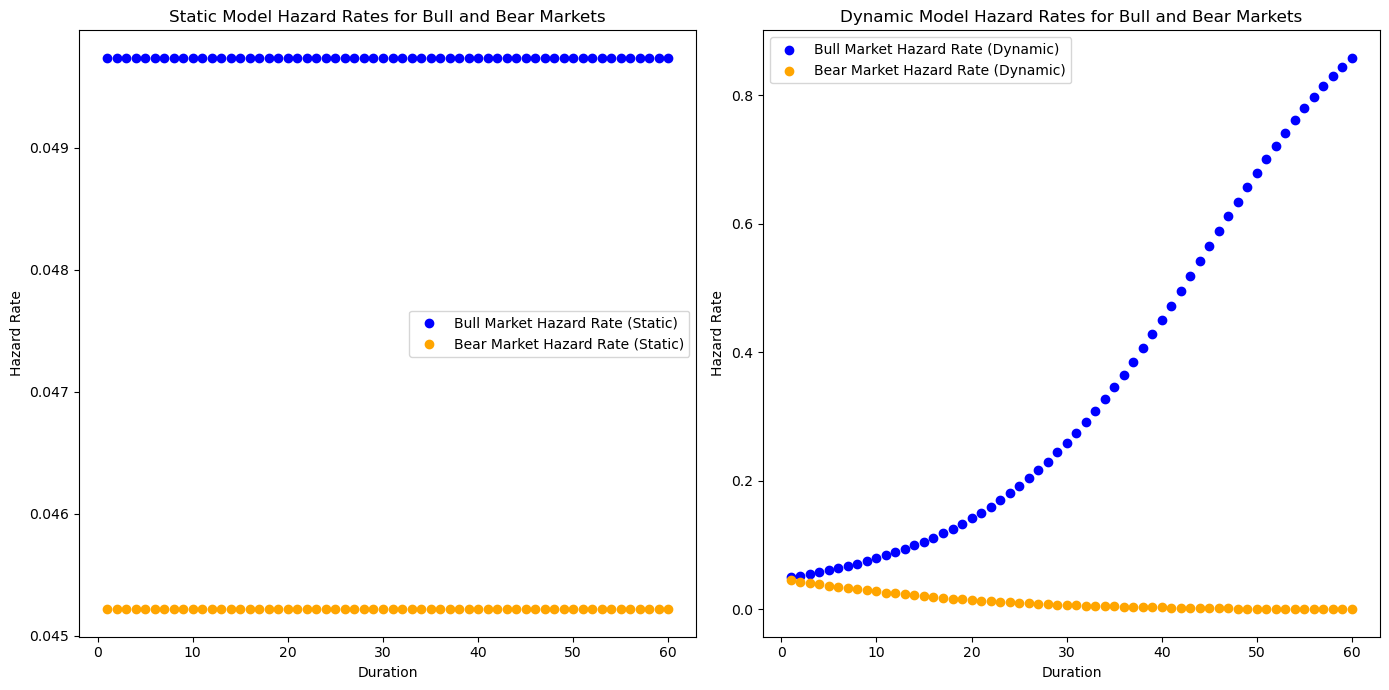

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

# Define the Logit link function for the hazard rate (static model)
def static_hazard_rate(x, beta):
    return sigmoid(np.dot(x, beta))

# Define the Logit link function for the hazard rate (dynamic model)
def dynamic_hazard_rate(x, betas):
    hazard_rates = []
    for i in range(len(x)):
        hazard_rates.append(sigmoid(np.dot(x[i], betas[i])))
    return np.array(hazard_rates)

# Define the survival function from the hazard rates
def survival_function(hazard_rates):
    return np.cumprod(1 - hazard_rates)

# Actual durations data (adjusted based on the example)
durations = np.arange(1, 61)  # Example durations (1 to 60 months)

# Static model coefficients (replace with actual values if available)
beta_bull_static = np.array([-3, 0.05])  # Coefficients for bull market (static)
beta_bear_static = np.array([-3, -0.05])  # Coefficients for bear market (static)

# Dynamic model coefficients (replace with actual values if available)
beta_bull_dynamic = np.array([[-3, 0.05 + 0.0005 * t] for t in durations])
beta_bear_dynamic = np.array([[-3, -0.05 - 0.0005 * t] for t in durations])

# Covariates: constant term for static model
x_static = np.ones((len(durations), 2))  # Including an intercept term for simplicity

# Covariates: constant term and linear term for dynamic model
x_dynamic = np.vstack([np.ones_like(durations), durations]).T

# Calculate hazard rates for bull and bear markets (static model)
hazard_rates_bull_static = static_hazard_rate(x_static, beta_bull_static)
hazard_rates_bear_static = static_hazard_rate(x_static, beta_bear_static)

# Calculate hazard rates for bull and bear markets (dynamic model)
hazard_rates_bull_dynamic = dynamic_hazard_rate(x_dynamic, beta_bull_dynamic)
hazard_rates_bear_dynamic = dynamic_hazard_rate(x_dynamic, beta_bear_dynamic)

# Calculate survival functions
survival_bull_static = survival_function(hazard_rates_bull_static)
survival_bear_static = survival_function(hazard_rates_bear_static)
survival_bull_dynamic = survival_function(hazard_rates_bull_dynamic)
survival_bear_dynamic = survival_function(hazard_rates_bear_dynamic)

# Plot the results as dots
plt.figure(figsize=(14, 7))

# Static model
plt.subplot(1, 2, 1)
plt.scatter(durations, hazard_rates_bull_static, label='Bull Market Hazard Rate (Static)', color='blue')
plt.scatter(durations, hazard_rates_bear_static, label='Bear Market Hazard Rate (Static)', color='orange')
plt.xlabel('Duration')
plt.ylabel('Hazard Rate')
plt.title('Static Model Hazard Rates for Bull and Bear Markets')
plt.legend()

# Dynamic model
plt.subplot(1, 2, 2)
plt.scatter(durations, hazard_rates_bull_dynamic, label='Bull Market Hazard Rate (Dynamic)', color='blue')
plt.scatter(durations, hazard_rates_bear_dynamic, label='Bear Market Hazard Rate (Dynamic)', color='orange')
plt.xlabel('Duration')
plt.ylabel('Hazard Rate')
plt.title('Dynamic Model Hazard Rates for Bull and Bear Markets')
plt.legend()

plt.tight_layout()
plt.show()


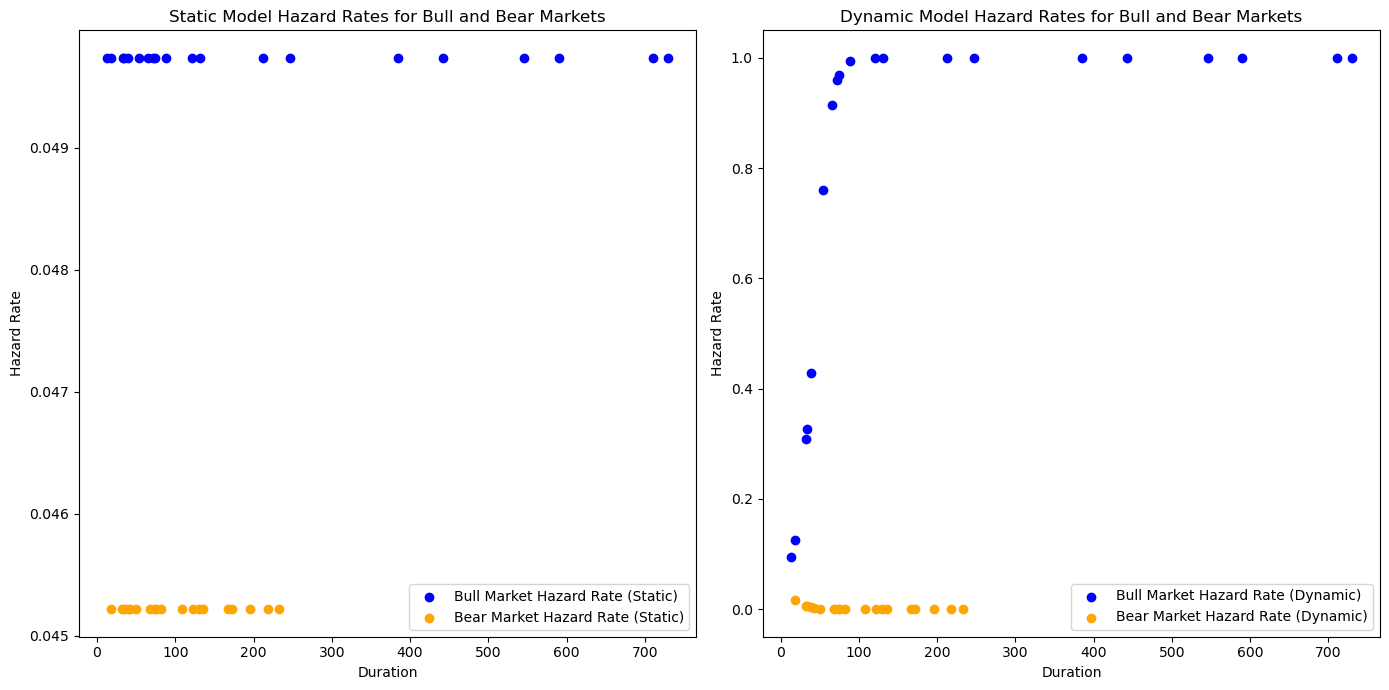

In [202]:

bull_durations = ACTUAL_BULL_DURATION['Duration'].values
bear_durations = ACTUAL_BEAR_DURATION['Duration'].values

# Static model coefficients (replace with actual values if available)
beta_bull_static = np.array([-3, 0.05])  # Coefficients for bull market (static)
beta_bear_static = np.array([-3, -0.05])  # Coefficients for bear market (static)

# Dynamic model coefficients (replace with actual values if available)
beta_bull_dynamic = np.array([[-3, 0.05 + 0.0005 * t] for t in bull_durations])
beta_bear_dynamic = np.array([[-3, -0.05 - 0.0005 * t] for t in bear_durations])

# Covariates: constant term for static model
x_static_bull = np.ones((len(bull_durations), 2))  # Including an intercept term for simplicity
x_static_bear = np.ones((len(bear_durations), 2))  # Including an intercept term for simplicity

# Covariates: constant term and linear term for dynamic model
x_dynamic_bull = np.vstack([np.ones_like(bull_durations), bull_durations]).T
x_dynamic_bear = np.vstack([np.ones_like(bear_durations), bear_durations]).T

# Calculate hazard rates for bull and bear markets (static model)
hazard_rates_bull_static = static_hazard_rate(x_static_bull, beta_bull_static)
hazard_rates_bear_static = static_hazard_rate(x_static_bear, beta_bear_static)

# Calculate hazard rates for bull and bear markets (dynamic model)
hazard_rates_bull_dynamic = dynamic_hazard_rate(x_dynamic_bull, beta_bull_dynamic)
hazard_rates_bear_dynamic = dynamic_hazard_rate(x_dynamic_bear, beta_bear_dynamic)

# Calculate survival functions
survival_bull_static = survival_function(hazard_rates_bull_static)
survival_bear_static = survival_function(hazard_rates_bear_static)
survival_bull_dynamic = survival_function(hazard_rates_bull_dynamic)
survival_bear_dynamic = survival_function(hazard_rates_bear_dynamic)

# Plot the results as dots
plt.figure(figsize=(14, 7))

# Static model
plt.subplot(1, 2, 1)
plt.scatter(bull_durations, hazard_rates_bull_static, label='Bull Market Hazard Rate (Static)', color='blue')
plt.scatter(bear_durations, hazard_rates_bear_static, label='Bear Market Hazard Rate (Static)', color='orange')
plt.xlabel('Duration')
plt.ylabel('Hazard Rate')
plt.title('Static Model Hazard Rates for Bull and Bear Markets')
plt.legend()

# Dynamic model
plt.subplot(1, 2, 2)
plt.scatter(bull_durations, hazard_rates_bull_dynamic, label='Bull Market Hazard Rate (Dynamic)', color='blue')
plt.scatter(bear_durations, hazard_rates_bear_dynamic, label='Bear Market Hazard Rate (Dynamic)', color='orange')
plt.xlabel('Duration')
plt.ylabel('Hazard Rate')
plt.title('Dynamic Model Hazard Rates for Bull and Bear Markets')
plt.legend()

plt.tight_layout()
plt.show()

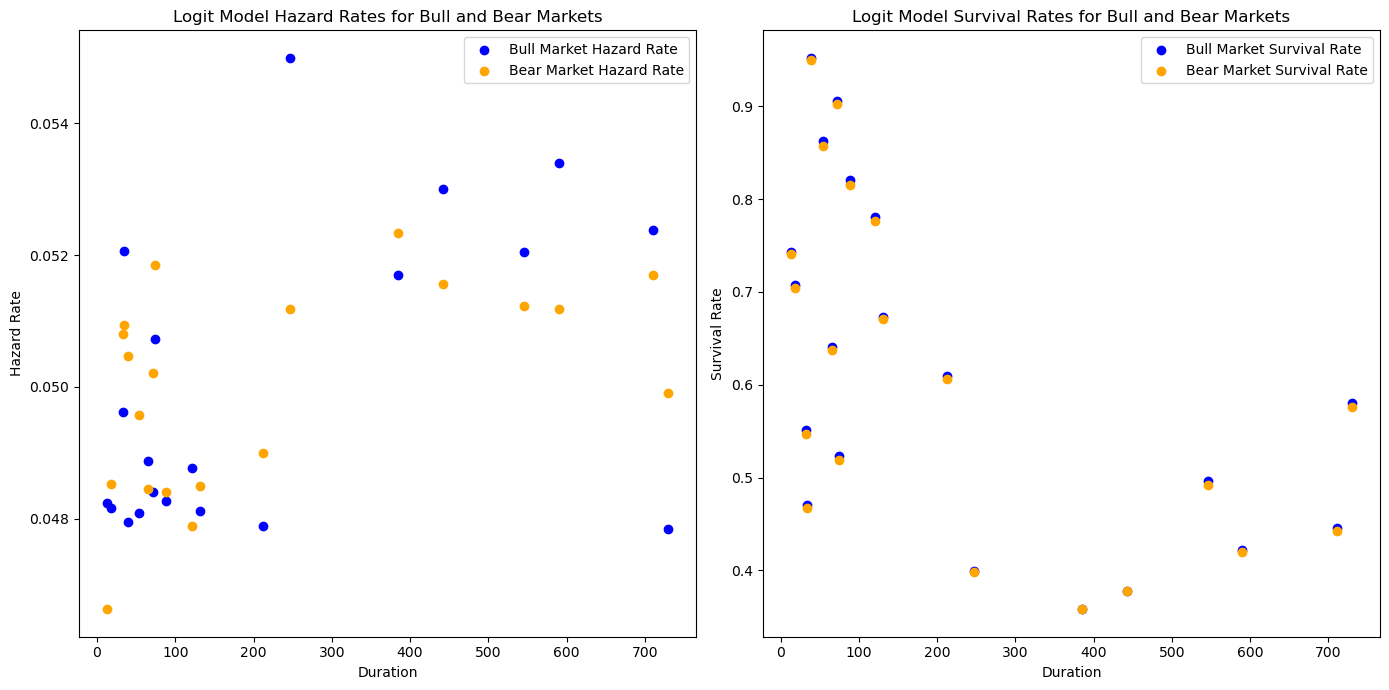

In [206]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

# Define the Logit link function
def logit_hazard(x, alpha):
    return sigmoid(x * alpha)

# Generate alpha_t based on the provided formulas
def generate_alpha(t, g0, sigma_0, sigma_xi):
    alpha = np.zeros(t)
    alpha[0] = np.random.normal(g0, sigma_0)
    for i in range(1, t):
        alpha[i] = alpha[i-1] + np.random.normal(0, sigma_xi)
    return alpha

# Duration data (replace with actual data)
#durations = np.arange(1, 61)  # Example durations (1 to 60 months)
durations = ACTUAL_BULL_DURATION['Duration'].values
# Parameters for alpha_t generation
g0 = -3  # Initial mean value
sigma_0 = 0.05  # Initial standard deviation
sigma_xi = 0.02  # Standard deviation for noise

# Generate alpha_t for the durations
alpha_t_bull = generate_alpha(len(durations), g0, sigma_0, sigma_xi)
alpha_t_bear = generate_alpha(len(durations), g0, sigma_0, sigma_xi)

# Covariates: constant term
x = np.ones(len(durations))  # Constant term for simplicity

# Calculate hazard rates using the logit link function
hazard_rates_bull = logit_hazard(x, alpha_t_bull)
hazard_rates_bear = logit_hazard(x, alpha_t_bear)

# Calculate survival functions
survival_bull = survival_function(hazard_rates_bull)
survival_bear = survival_function(hazard_rates_bear)

# Plot the results as dots
plt.figure(figsize=(14, 7))

# Hazard rates
plt.subplot(1, 2, 1)
plt.scatter(durations, hazard_rates_bull, label='Bull Market Hazard Rate', color='blue')
plt.scatter(durations, hazard_rates_bear, label='Bear Market Hazard Rate', color='orange')
plt.xlabel('Duration')
plt.ylabel('Hazard Rate')
plt.title('Logit Model Hazard Rates for Bull and Bear Markets')
plt.legend()

# Survival rates
plt.subplot(1, 2, 2)
plt.scatter(durations, survival_bull, label='Bull Market Survival Rate', color='blue')
plt.scatter(durations, survival_bear, label='Bear Market Survival Rate', color='orange')
plt.xlabel('Duration')
plt.ylabel('Survival Rate')
plt.title('Logit Model Survival Rates for Bull and Bear Markets')
plt.legend()

plt.tight_layout()
plt.show()

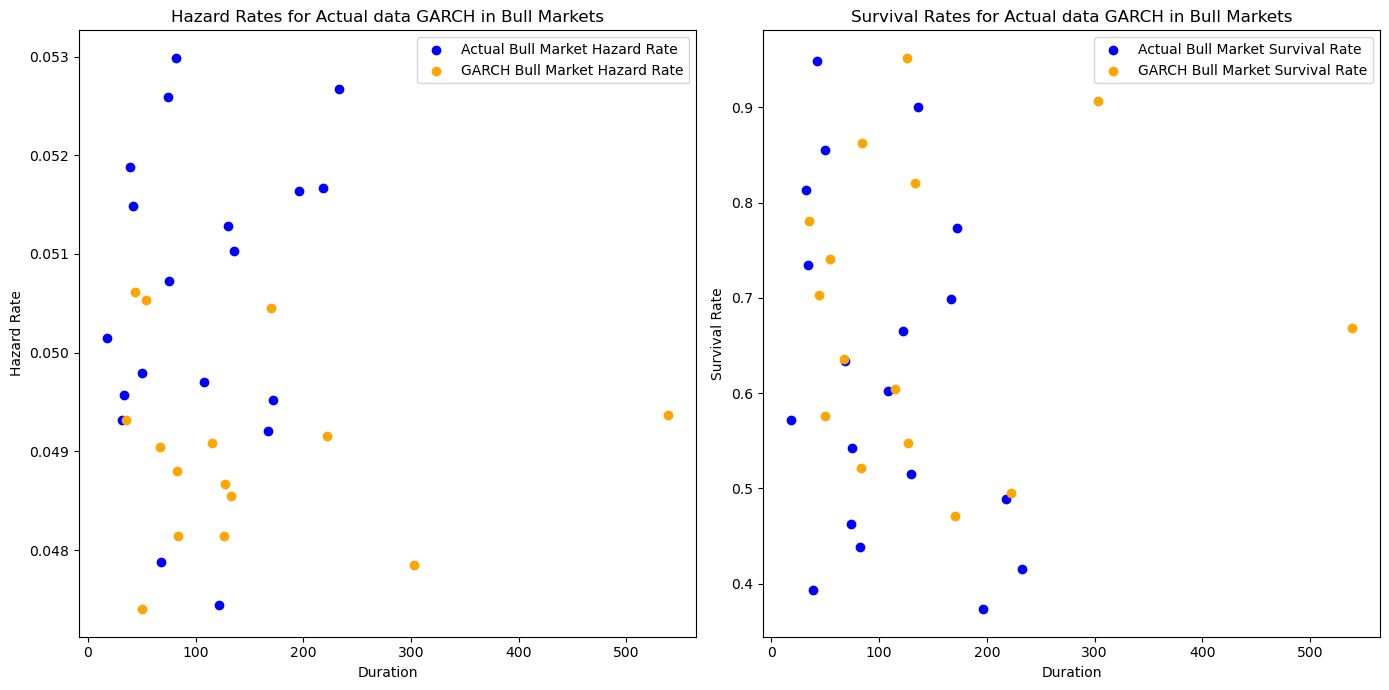

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

# Define the Logit link function
def logit_hazard(x, alpha):
    return sigmoid(x * alpha)

# Generate alpha_t based on the provided formulas
def generate_alpha(t, g0, sigma_0, sigma_xi):
    alpha = np.zeros(t)
    alpha[0] = np.random.normal(g0, sigma_0)
    for i in range(1, t):
        alpha[i] = alpha[i-1] + np.random.normal(0, sigma_xi)
    return alpha

# Actual durations data (replace with your actual data)
### BULL
actual_durations = ACTUAL_BEAR_DURATION['Duration'].values # Example data, replace with ACTUAL_BULL_DURATION['Duration'].values
garch_durations = GARCH_BEAR_DURATION['Duration'].values # Example data, replace with ACTUAL_BEAR_DURATION['Duration'].values

# Parameters for alpha_t generation
g0 = -3  # Initial mean value
sigma_0 = 0.05  # Initial standard deviation
sigma_xi = 0.02  # Standard deviation for noise

# Generate alpha_t for the durations
alpha_t_actual = generate_alpha(len(actual_durations), g0, sigma_0, sigma_xi)
alpha_t_garch = generate_alpha(len(garch_durations), g0, sigma_0, sigma_xi)

# Covariates: constant term
x_actual = np.ones(len(actual_durations))  # Constant term for simplicity
x_garch = np.ones(len(garch_durations))  # Constant term for simplicity

# Calculate hazard rates using the logit link function
hazard_rates_actual = logit_hazard(x_actual, alpha_t_actual)
hazard_rates_garch = logit_hazard(x_garch, alpha_t_garch)

# Define the survival function from the hazard rates
def survival_function(hazard_rates):
    return np.cumprod(1 - hazard_rates)

# Calculate survival functions
survival_actual = survival_function(hazard_rates_actual)
survival_garch = survival_function(hazard_rates_garch)

# Plot the results as dots
plt.figure(figsize=(14, 7))

# Hazard rates
plt.subplot(1, 2, 1)
plt.scatter(actual_durations, hazard_rates_actual, label='Actual Bull Market Hazard Rate', color='blue')
plt.scatter(garch_durations, hazard_rates_garch, label='GARCH Bull Market Hazard Rate', color='orange')
plt.xlabel('Duration')
plt.ylabel('Hazard Rate')
plt.title('Hazard Rates for Actual data GARCH in Bull Markets')
plt.legend()

# Survival rates
plt.subplot(1, 2, 2)
plt.scatter(actual_durations, survival_actual, label='Actual Bull Market Survival Rate', color='blue')
plt.scatter(garch_durations, survival_garch, label='GARCH Bull Market Survival Rate', color='orange')
plt.xlabel('Duration')
plt.ylabel('Survival Rate')
plt.title('Survival Rates for Actual data GARCH in Bull Markets')
plt.legend()

plt.tight_layout()
plt.savefig('Downloads/Hazard rate.png')
